<a href="https://colab.research.google.com/github/vatsalsaglani/DL-for-coders-part1-2019/blob/master/DL_LESSON_3_CAMVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Lesson 3: IMAGE SEGMENTATION - CAMVID</h1></center>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

<center><h2>Load Data</h2></center>

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

<center><h2>Data</h2></center>

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_04860.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06000.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_02040.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01830_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07830_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010200_P.png')]

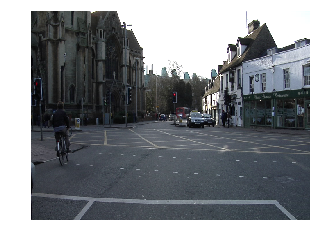

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize = (5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

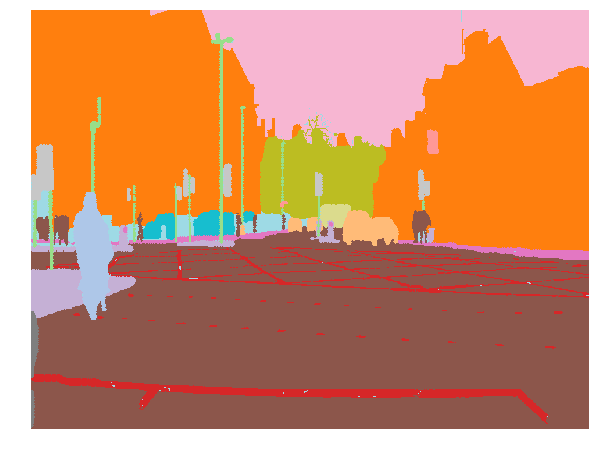

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize = (10,10), alpha = 1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [22, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype = str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

<center><h2>Datasets</h2></center>

In [0]:
size = src_size//2 # integer divide
bs = 8

In [0]:
# # older version (doesn't work)
# src = (ImageFileList.from_folder(path_img)
#        .label_from_func(get_y_fn)
#        .split_by_fname_file('../valid.txt'))
# new version works
src = (SegmentationItemList
       .from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))


In [0]:
# # old version that doesn't work
# data = (src.datasets(SegmentationDataset, classes = codes)
#         .transform(get_transforms(), size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))
# new version that works
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))



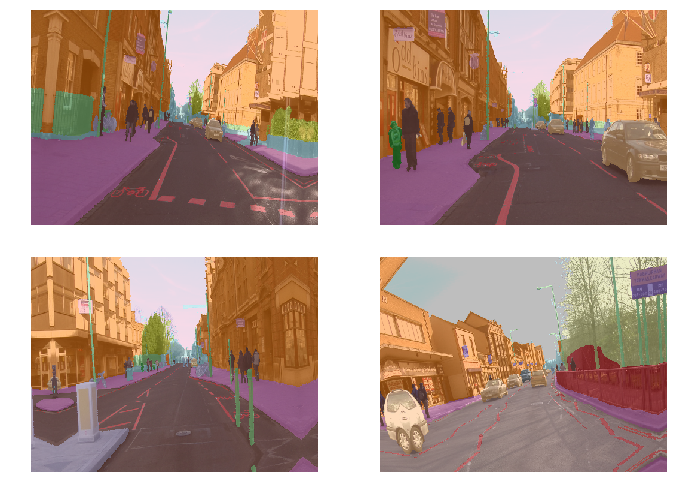

In [19]:
data.show_batch(2, figsize = (10, 7))

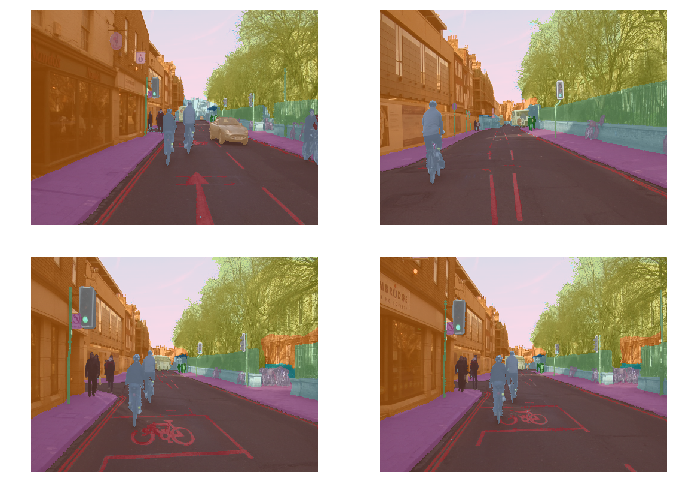

In [20]:
data.show_batch(2, figsize = (10, 7), ds_type = DatasetType.Valid)

<center><h2>Model</h2></center>

In [0]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim = 1)[mask] == target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [23]:
learn = unet_learner(data, models.resnet34, metrics = metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 23897678.79it/s]


epoch,train_loss,valid_loss,acc_camvid


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


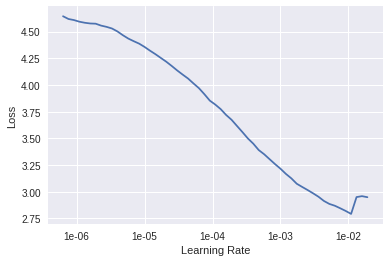

In [25]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-2

In [27]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid
1,1.321497,0.908836,0.745775
2,7.163889,4.118923,0.179449
3,3.813725,1.984144,0.305262
4,2.044335,1.636855,0.479296
5,1.572136,1.639075,0.519322
6,1.422844,1.508567,0.511519
7,1.363265,1.525446,0.538611
8,1.309514,1.453293,0.532208
9,1.292939,1.436684,0.536702
10,1.272353,1.428817,0.533754


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-5, lr/5)

In [32]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,1.259184,1.432751,0.514925
2,1.266930,1.408704,0.503865
3,1.263764,1.450780,0.536437
4,1.253024,1.366456,0.548666
5,1.245132,1.372648,0.561788
6,1.218122,1.365943,0.551164
7,1.204554,1.352552,0.538667
8,1.173204,1.330118,0.562316
9,1.173111,1.327114,0.561792
10,1.150383,1.330754,0.554643


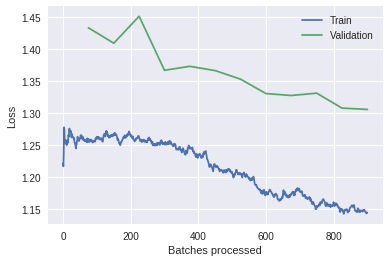

In [33]:
learn.recorder.plot_losses()

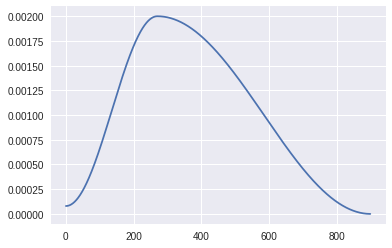

In [34]:
learn.recorder.plot_lr()

In [0]:
learn.save('stage-2')

<center><h1>Go Big</h1></center>

In [0]:
size = src_size
bs = 4

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics = metrics)

In [0]:
learn.load('stage-2');

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
learn.load('stage-1-big')

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6, lr)

In [0]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big')

In [0]:
learn.show_results()